In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from pathlib import Path

In [2]:
Drugs = ['ARTHROTEC', 'CAMBIA', 'CATAFLAM', 'DICLOFENAC-POTASSIUM', 'DICLOFENAC-SODIUM',
         'FLECTOR', 'LIPITOR', 'PENNSAID', 'SOLARAZE', 'VOLTAREN', 'VOLTAREN-XR', 'ZIPSOR']

# EDA

Take a look at patient 1 who takes Arthrotec.

In [ ]:
# all detected entities
pd.read_csv("E:\TM\Final\CADEC\original\ARTHROTEC.1.ann", sep='\t', header=None)

In [ ]:
# terms tagged with ADR that are mapped to MedDRA database
pd.read_csv("E:\TM\Final\CADEC\meddra\ARTHROTEC.1.ann", sep='\t', header=None)

In [ ]:
# Non-drug terms mapped to SCT database
pd.read_csv("E:\TM\Final\CADEC\sct\ARTHROTEC.1.ann", sep='\t', header=None)

## Types of Name Entities

Not every report has name entities labelled. For those that do, there are $6$ types of name entities: **ADR, AnnotatorNotes, Disease, Drug, Finding, Symptom**. All drugs but FLECTOR have some words in the reports tagged as ADR. The distributions of entity tags are rather different across drugs, except for VOLTAREN and VOLTAREN-XR.

In [3]:
num_Reports = dict()    # dictionary: drug --> the number of reports 
print('Number of Reports for each drug: \n')
for drug in Drugs:
    Files = Path('E:/TM/Final/CADEC/original').glob(drug+'*.ann')
    num_Reports[drug] = sum([1 for file in Files])
    print(drug, '-->', num_Reports[drug])

Number of Reports for each drug: 

ARTHROTEC --> 145
CAMBIA --> 4
CATAFLAM --> 10
DICLOFENAC-POTASSIUM --> 3
DICLOFENAC-SODIUM --> 7
FLECTOR --> 1
LIPITOR --> 1000
PENNSAID --> 4
SOLARAZE --> 3
VOLTAREN --> 68
VOLTAREN-XR --> 22
ZIPSOR --> 5


In [4]:
Tags = dict()  # a dictionary: drug --> a list of tags
Empty_tags = dict()   # a dictionary: drug --> the number of reports without any name entities labelled

for drug in Drugs:
    print(drug, ':')
    Files = Path('E:/TM/Final/CADEC/original').glob(drug+'*.ann')
    lst = list()
    count = 0
    for file in Files:
        try:
            data = pd.read_csv(file, sep='\t', header=None)
            lst.extend(data.iloc[:,1].tolist())
        except:
            st = os.stat(file)
            print(st.st_size, 'bytes <--', file)
            count += 1
    print('\n')
    Tags[drug] = lst
    Empty_tags[drug] = count

ARTHROTEC :


CAMBIA :
0 bytes <-- E:\TM\Final\CADEC\original\CAMBIA.1.ann


CATAFLAM :


DICLOFENAC-POTASSIUM :


DICLOFENAC-SODIUM :


FLECTOR :


LIPITOR :
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.197.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.243.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.28.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.285.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.299.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.308.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.313.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.383.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.4.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.40.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.41.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.416.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.437.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.438.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.444.ann
0 bytes <-- E:\TM\Fin

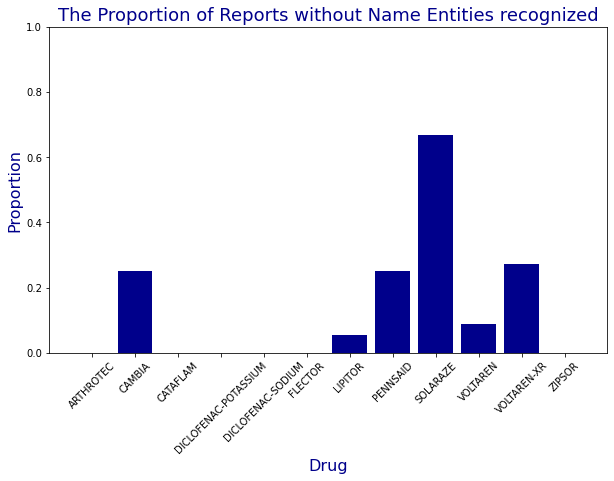

In [5]:
# the proportion of reports without any entities labelled
plt.figure(figsize=(10,6))
plt.bar(Drugs, [Empty_tags[drug]/num_Reports[drug] for drug in Drugs], color='darkblue')
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.xlabel('Drug', fontsize=16, color='darkblue')
plt.ylabel('Proportion', fontsize=16, color='darkblue')
plt.title('The Proportion of Reports without Name Entities recognized', fontsize=18, color='darkblue')
plt.show()

In [6]:
# types of name entities for each drug
for drug in Drugs:
    lst = [re.findall('(\S+)\s', ele)[0] for ele in Tags[drug]]  # extract the 1st part of a tag
    lst = list(set(lst))
    lst.sort()
    print(drug, '-->', lst, '\n')

ARTHROTEC --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Finding', 'Symptom'] 

CAMBIA --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Finding'] 

CATAFLAM --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Finding', 'Symptom'] 

DICLOFENAC-POTASSIUM --> ['ADR', 'AnnotatorNotes', 'Symptom'] 

DICLOFENAC-SODIUM --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Symptom'] 

FLECTOR --> ['Disease', 'Drug', 'Symptom'] 

LIPITOR --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Finding', 'Symptom'] 

PENNSAID --> ['ADR', 'AnnotatorNotes', 'Drug', 'Finding', 'Symptom'] 

SOLARAZE --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug'] 

VOLTAREN --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Finding', 'Symptom'] 

VOLTAREN-XR --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Finding', 'Symptom'] 

ZIPSOR --> ['ADR', 'Disease', 'Drug', 'Finding', 'Symptom'] 



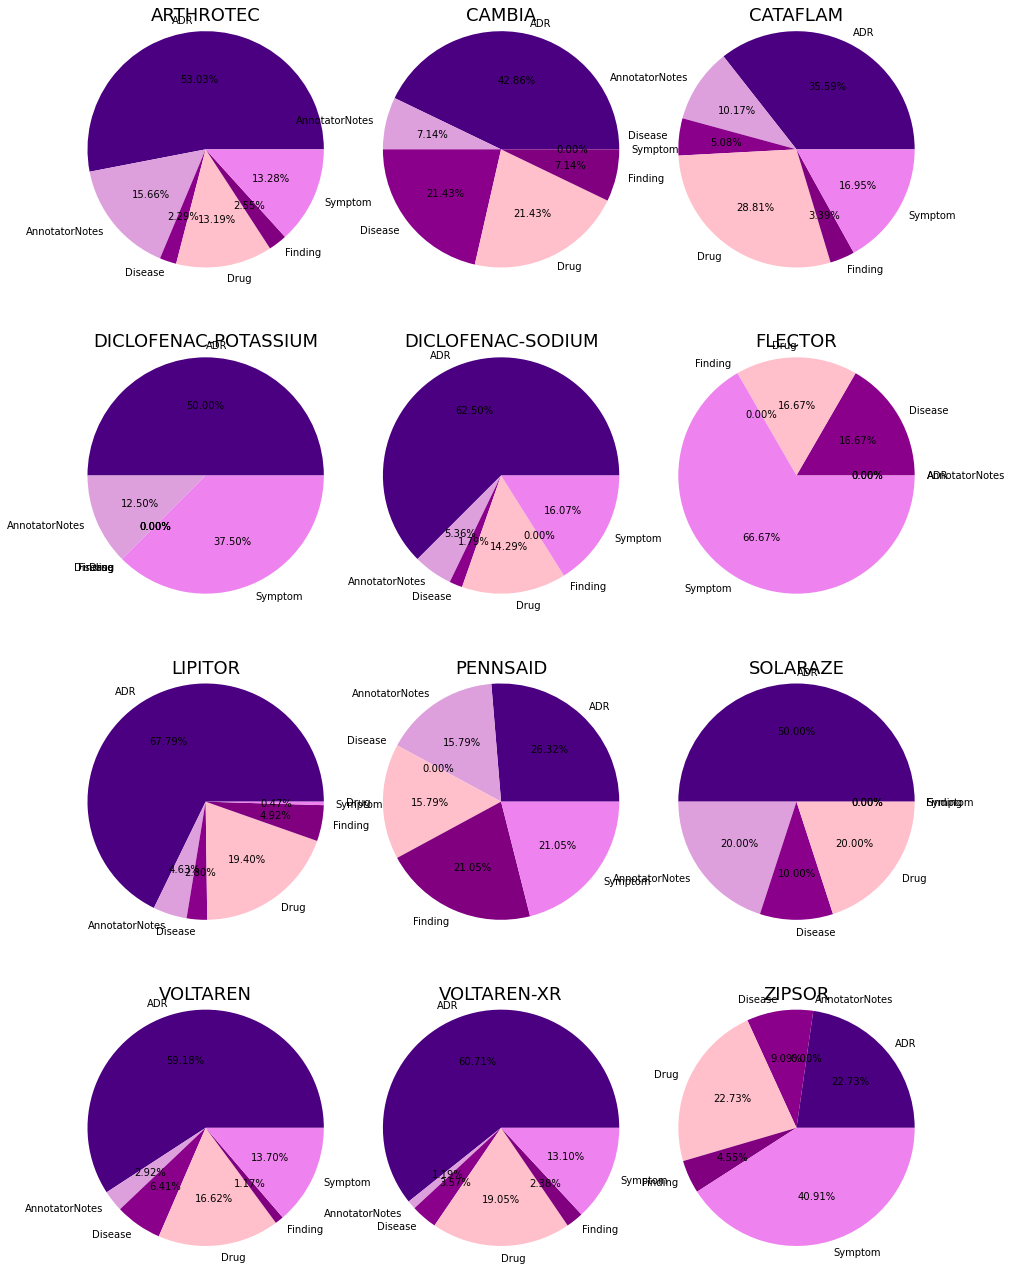

In [30]:
row,col,r = 4,3,1.2
CLR = ['indigo', 'plum', 'darkmagenta', 'pink', 'purple', 'violet']

def count_tags(raw_tags):
    Count_NE = dict()
    for entity in ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Finding', 'Symptom']:
        Count_NE[entity] = sum([1 for ele in raw_tags if ele.startswith(entity)])
    return Count_NE

pic,axes = plt.subplots(row,col, figsize=(15,23))
for k, drug in enumerate(Drugs):
    data =count_tags(Tags[drug])
    i = int(k/col)
    j = k - col*i
    axes[i,j].pie(list(data.values()), labels=tuple(data.keys()), autopct='%1.2f%%', colors=CLR, radius=r)
    axes[i,j].set_title(drug, fontsize=18)
plt.show()

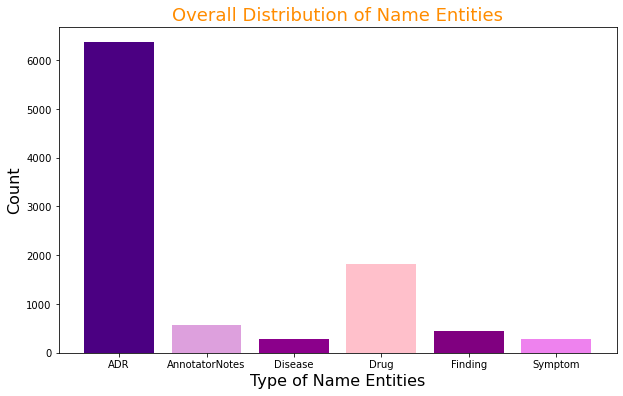

In [39]:
# overall distribution of name entities regardless of drug
plt.figure(figsize=(10,6))
plt.bar(['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Finding', 'Symptom'],
        count_tags([ele for sublist in Tags.values() for ele in sublist]).values(),
        color = CLR)
plt.xlabel('Type of Name Entities', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Overall Distribution of Name Entities', fontsize=18, color='darkorange')
plt.show()

# Adverse Drug Effect (ADR tags)

In [31]:
# the number of raw tags for each drug
for drug in Drugs:
    print(drug, ":", len(Tags[drug]))

ARTHROTEC : 1137
CAMBIA : 14
CATAFLAM : 59
DICLOFENAC-POTASSIUM : 8
DICLOFENAC-SODIUM : 56
FLECTOR : 6
LIPITOR : 8012
PENNSAID : 19
SOLARAZE : 10
VOLTAREN : 343
VOLTAREN-XR : 84
ZIPSOR : 22


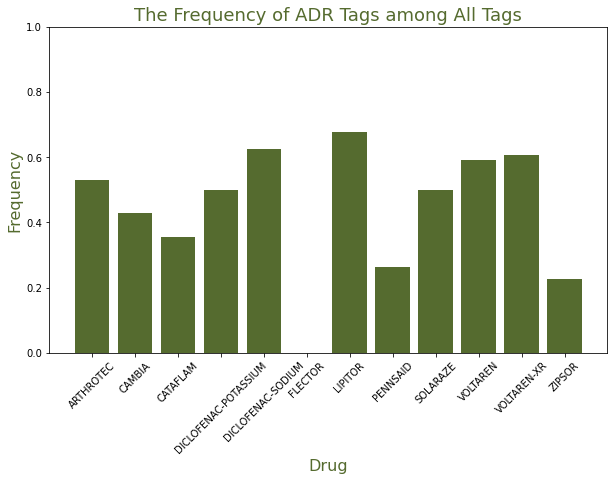

In [32]:
# frequency of ADR tags for each drug
def freq_ADR(tags):
    return sum([tag.startswith('ADR') for tag in tags]) / len(tags)

plt.figure(figsize=(10,6))
plt.bar(Drugs, [freq_ADR(Tags[drug]) for drug in Drugs], color='darkolivegreen')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.xlabel('Drug', fontsize=16, color='darkolivegreen')
plt.ylabel('Frequency', fontsize=16, color='darkolivegreen')
plt.title('The Frequency of ADR Tags among All Tags', fontsize=18, color='darkolivegreen')
plt.show()

# Pre-processing

Represent each sentence as a list of pairs (word, OBI).

# Decision Tree / Random Forest

# Conditional Random Field

# BioBERT